# Predict Options Volatility index

### In this notebook, We will predict the next day's Volailtility of selected Options based on historical volatility using RNN LSTM model. We will also train the model with additional features such as Realized Volatility from the Stock closing prices, etc.,

### We will use RNN as a classifier for building tensorflow LSTM model.

In [1]:
#initial imports
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.graph_objects as go
import alpaca_trade_api as tradeapi
from pathlib import Path
from dotenv import get_key
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# initialize alpaca API and set parameters
api_key=get_key(".env", "ALPACA_API_KEY")
secret_key=get_key(".env", "ALPACA_SECRET_KEY")
tickers=['AAPL', 'AMZN', 'GS', 'IBM']
start='2017-11-01'
end='2020-11-07'

In [3]:
#check if ticker data exists in local directory/ saved earlier into csv file.
#if exists, load the data
def load_csv(path, tickers):
    df_dict={}
    for file in Path(path).glob('*.csv'):
        ticker=file.name.split('.')[0]
        if ticker in tickers:
            df_dict[ticker]=pd.read_csv(file, parse_dates=True, infer_datetime_format=True, 
                                 index_col=0, delimiter=',')
            tickers.remove(ticker)
    return  df_dict, tickers

In [4]:
#if ticker data was not saved in local directory, fetch from alpaca
def fetch_api_data(api_key, secret_key, tickers, start, end):
    """fetch daily ticker data using API if the ticker data is not already saved before"""
  
    df_dict={}
    alpaca = tradeapi.REST(api_key, secret_key, api_version="v2")
    today=pd.Timestamp("2020-08-19", tz="America/Chicago").isoformat()
    timeframe="1D"
    tf_start = start
    tf_end= end
    for ticker in tickers:
        df_portfolio = alpaca.get_barset(ticker, timeframe, start=tf_start, end=tf_end).df
        df_dict.update({ticker: df_portfolio[ticker]})
    return df_dict

In [5]:
#create data frame with close prices of each ticker
def get_daily_close(dict):

    df_close=pd.DataFrame()
    for ticker in df_dict:
        df_dict[ticker].to_csv(ticker+'.csv', date_format='%Y-%m-%d')
        df_close[ticker+'_close']=df_dict[ticker]['close']
    df_close.index= pd.DatetimeIndex(df_close.index)
    return df_close

In [6]:
def get_returns_df(data):
    """create a daily returns data frame using OHLC"""
    for col in data:
        ticker = col.split('_')[0]
        data[ticker+'_pc'] = data[col].pct_change().replace([np.inf, -np.inf], np.nan).dropna()
    return data

In [7]:
def get_volaitlity(data, window):
    """compute historical volatility/standard deviations 
    of close price returns over last N days (window) and that can be used to predict next day volatility """
 
    for col in data:
        ticker = col.split('_')[0]
        if col.split('_')[1] == 'pc':
            data[ticker+'_vol'] = np.nan
            volatility = []
            for i in range(window, len(data[col])):
                volatility.append(np.std(data[col][i-window:i]))
            data[ticker+'_vol'].iloc[window:]=volatility
            data[ticker+'_vol'].fillna(0., inplace=True)

    return data

In [8]:
#read the vix  data from txt files in a folder
def get_vix_data(path):
    vix_df=pd.DataFrame()
    vixdf=[]
    for vix_file in Path(path).glob('*.txt'):
        vix=vix_file.name.split('.')[0]
        temp_df=pd.read_csv(vix_file, parse_dates=True, infer_datetime_format=True, 
                            usecols=['Date', 'Close'], index_col='Date', delimiter=',')
        temp_df.columns=[vix]
        vixdf.append(temp_df)

    vix_df= pd.concat((vix for vix in vixdf), axis=1)
    return vix_df

In [207]:
# Create the features (X) and the target (y)
# this function chunks the data up with a rolling window of Xt-n to predict Xt and returns a numpy array of X any y
def window_data(df, columns, window, feature_col_number, target_col_number, fcast):
    X = []
    y = []
    fcount = len(columns)
    if fcount > 1:  # should our data set has the Open high low close and volume features
        for i in range(len(df)- window -fcast): 
            try:
                feature_stack=[]
                for j in range(fcount):
                    feature_stack.append(df.iloc[i:(i + window), columns[j]])
                    #h = df.iloc[i:(i + window), 1] 
                    #l = df.iloc[i:(i + window), 2] 
                    #c = df.iloc[i:(i + window), 3] 
                #v = df['volume'][i:i+WINDOW] # we donot have volume data in our data set. if available, enable this code.
                #features = np.column_stack(feature_stack)
                target = df.iloc[(i + window + fcast), target_col_number]
                X.append(np.column_stack(feature_stack))
                y.append(target)
            except Exception as e:
                break
    else:
        for i in range(len(df)- window - fcast): 
            try:
                features = df.iloc[i:(i + window), columns[0]] 
                target = df.iloc[(i + window + fcast), target_col_number]
                X.append(features)
                y.append(target)
            
            except Exception as e:
                break
    #test_target = df.shift(5)
    return np.array(X), np.array(y).reshape(-1, 1)


In [10]:
# create train and test split and scale the data to 0 & 1 using minmaxscaler 
# use the same function to descale/inverse transform by passsing a variable 'type'
def get_scaled_data(X, y):
    global scaler # we will use the same scaler instance outside the function to inverse transform the output
    # Use 70% of the data for training and the remaineder for testing
    split=int(0.7*len(X))
    X_train = X[:split]
    X_test = X[split:]
    y_train = y[:split]
    y_test = y[split:]

    # Create a MinMaxScaler object
    scaler=MinMaxScaler()
    # Fit the MinMaxScaler object with the features data X
    
    # Scale the features training and testing sets
    try:
        scaler.fit(X_train)
        X_train =scaler.transform(X_train)
        X_test =scaler.transform(X_test)
    except:
        # for more than 2d vectors - added 11/12 
        scalers = {}
        for i in range(X_train.shape[1]):
            scalers[i] = MinMaxScaler()
            X_train[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

        for i in range(X_test.shape[1]):
            X_test[:, i, :] = scalers[i].transform(X_test[:, i, :]) 
    #Fit the MinMaxScaler object with the target data Y
    scaler.fit(y)
    #Scale the target training and testing sets
    y_train =scaler.transform(y_train)
    y_test =scaler.transform(y_test)
    
    
    
    return X_train, X_test, y_train, y_test

In [42]:
# Build & compile LSTM model. 
def build_compile_model(n_units, dropout_fraction, X_train, loss, optimizer, emb_size): #emb_size added - 11/13
    model = Sequential()
    #first LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))) # emb_Size (2)
    model.add(Dropout(dropout_fraction))
    #2nd LSTM layer
    model.add(LSTM(units=n_units, return_sequences=True))
    model.add(Dropout(dropout_fraction))
    #3rd LSTM layer
    model.add(LSTM(units=n_units))
    model.add(Dropout(dropout_fraction))
    #outputlayer
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [105]:
# Make predictions
def  get_predictions(test_data, actual_data, df, pred_model): # added pred_model as parameter - 11/13
    """returns predictions Vs actuals dataframe"""
    predicted=pred_model.predict(test_data)
    predicted = scaler.inverse_transform(predicted)
    historical = scaler.inverse_transform(actual_data.reshape(-1, 1))
#     # Create a DataFrame of historical and Predicted values
#     output = pd.DataFrame({
#         "historical": historical.ravel(),
#         "Predicted": predicted.ravel()
#     }, index = df.index[-(len(actual_data)+5):])
    return predicted, historical

In [13]:
#save model
def save_model(model, filename):
    model.save(filename)
    return True

In [ ]:
#fetch ticker data if it was saved earlier into csv file. if not exist, use fetch from alpaca api
csv_path='./' #directory path where ticker data was saved
df_dict, tickers = load_csv(csv_path, tickers)
if len(tickers) > 0:
        df_dict= fetch_api_data(api_key, secret_key, tickers, start, end)
else:
    print(len(df_dict))

In [ ]:
#get daily close prices of different tickers into a df
df_close = get_daily_close(df_dict)
df_close.head()

In [ ]:
#append close prices data frame with percent change/daily returns columns
df_close = get_returns_df(df_close)
df_close.head()

In [ ]:
# call the function get_volatility by passing the window/n days to compute volatility and append the close prices df
df_close = get_volaitlity(df_close, 5)
df_close.sample()

In [142]:
#call the function by passing the file path where vix data files are stored
file_dir= './../vol_machine/resources/'
vix_df=get_vix_data(file_dir)
vix_df.tail()

,AAPLVIX,AMZNVIX,GSVIX,IBMVIX
Date,,,,
2020-11-02,47.39,47.33,43.75,37.07
2020-11-03,44.65,45.95,42.97,35.29
2020-11-04,41.20,41.84,36.90,31.10
2020-11-05,39.69,40.06,35.27,29.74
2020-11-06,36.68,38.13,34.04,28.39


In [16]:
#combine ticker close, returns & volatility dataframe with Vix Data frame. 
vol_vix_df = pd.concat([df_close.loc[:'2020-11-06'], vix_df.loc['2020-06-22':]], axis=1)
vol_vix_df.head()

NameError: name 'df_close' is not defined

In [ ]:
vol_vix_df.iloc[:, 4:8].plot(legend=True, figsize=(20,5), title='Daily Returns')

In [ ]:
vol_vix_df.iloc[:, 8:12].plot(legend=True, figsize=(20,5), title='5 day rolling volatlity')

In [ ]:
vol_vix_df.iloc[:, 12:16].plot(legend=True, figsize=(20,5), title='Daily Vix')

In [ ]:
# df_ibm = vol_vix_df[['IBM_vol', 'IBMVIX']]
# df_ibm.head()

#### Create the Features `X` and Target `y` Data
Use the `window_data()` function bellow, to create the features set `X` and the target vector `y`. 
Define a window size of `n` days and chose the feature and target columns;


In [215]:
# select the window of data  volaitlity  using a n day window of historical volatility
window_size = 5 
feature_column = 3   
target_column = 3    
features = [3] # pass the list of features. index # of hte feature column - updated 11/12
forecast = 5 # # of days to forecast. We will use historical data to forecast 1 day ahead
X, y = window_data(vix_df.loc[:'2020-11-01'], features, window_size, feature_column, target_column, forecast)

#### Split Data Between Training &  Testing Sets and Scale Data with `MinMaxScaler`

1. To avoid the dataset being randomized, manually create the training and testing sets using array slicing. 
Use 70% of the data for training and the remainder for testing.

2. Before training the RNN LSTM model, use the `MinMaxScaler` from `sklearn` to scale the training and testing data between `0` and `1`.

In [ ]:
len(X)

In [216]:
X_train, X_test, y_train, y_test = get_scaled_data(X, y)

In [217]:
X_train.shape

(1752, 5)

In [162]:
len(y_test)

751

#### Reshape Features Data for the LSTM Model
The LSTM API from Keras needs to receive the features data as a _vertical vector_, 
so that reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`. 
Both sets, training, and testing should be reshaped.

In [218]:
# Reshape the features data
X_train = np.reshape(X_train, (X_train.shape[0], len(features), X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], len(features), X_test.shape[1]))
# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:1]}")
print (f"X_test sample values:\n{X_test[:1]}")

X_train sample values:
[[[0.19142765 0.2188205  0.21753142 0.22784402 0.25974863]]]
X_test sample values:
[[[0.12504028 0.14212053 0.15243313 0.11923945 0.1434096 ]]]


## Build and Train the LSTM RNN

In this section, lets design a custom LSTM RNN and fit (train) it using the training data.

Steps:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data


In [219]:
#build & compile the model by calling the function and passing the parameters
units=100
dropout=0.2
loss='mean_squared_error'
optimizer='adam'
emb_size=len(features)
model = build_compile_model(units, dropout, X_train, loss, optimizer, emb_size=emb_size)

In [ ]:
# visualize the model archiecture. another way is to print the summary
tf.keras.utils.plot_model(model, to_file='ibmvix.png', show_shapes=True, show_layer_names=True, 
                          rankdir='LR', expand_nested=True, dpi=96)

In [220]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 1, 100)            42400     
_________________________________________________________________
dropout_27 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 100)            80400     
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 100)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_29 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [221]:
# Train the model with 10 epochs and without shuffle the data
# we can play with batch size parameter, but given a small data set, we can go with batch size of 1.
model.fit(X_train, y_train, validation_split=0.2, batch_size=100, epochs=100, shuffle=False, verbose=0)

## Model Performance

In this section, We will evaluate the model using the test data by:
1. Evaluating the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### note:
we will use `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [222]:
# Evaluate the model
model.evaluate(X_test, y_test, batch_size=5, verbose=1)

151/151 [==============================] - 1s 4ms/step - loss: 0.0054


0.005424359813332558

In [24]:
file=model.name + '16nov.tf'
save_model(model, file)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: sequential16nov.tf\assets


True

In [231]:
#get prediction results by passing X_test, y_test and the features dataframe
results = get_predictions(X_test, y_test, vix_df, model)
results_df = pd.DataFrame({'actual':results[1].ravel(), 'Predicted': results[0].ravel()}, index=vix_df.index[-len(results[1]):])
results_df['actual']= results_df['actual'].shift(5).fillna(0)
#results_df['historical'] = results_df['historical'].fillna(0)
#results_df['Predicted'] = results_df['Predicted'].shift(-5).fillna(0)
results_df.tail()

,actual,Predicted
Date,,
2020-11-02,34.01,31.177353
2020-11-03,29.62,30.786386
2020-11-04,31.51,28.161751
2020-11-05,30.23,28.663414
2020-11-06,30.69,27.847435


<AxesSubplot:title={'center':'Predicted Volatility'}, xlabel='Date'>

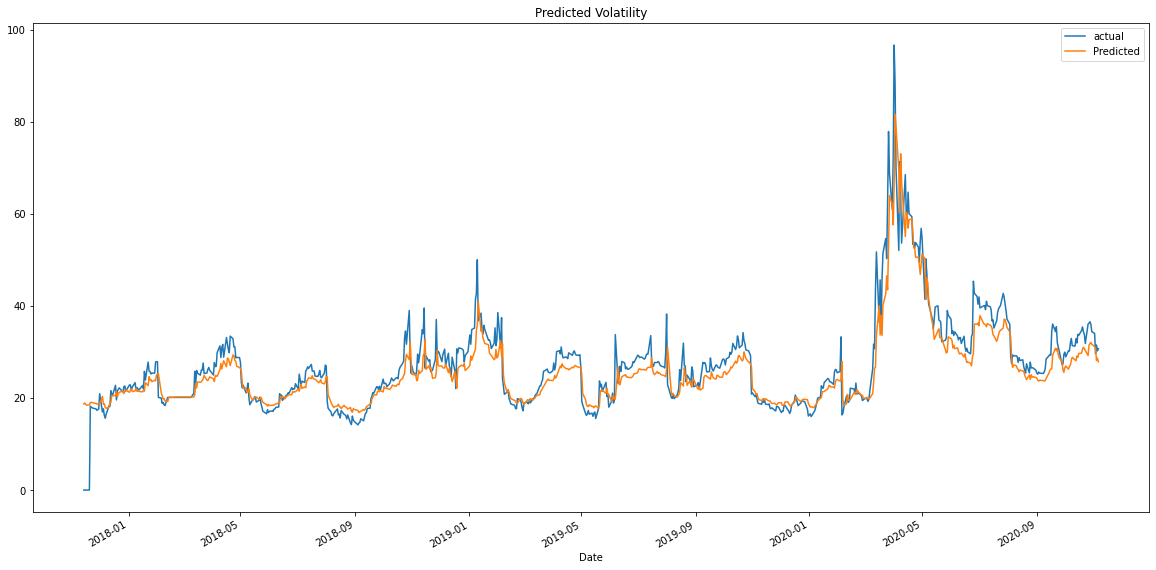

In [232]:
# Plot the real vs predicted values as a line chart
results_df.plot(figsize=(20, 10), title='Predicted Volatility', legend=True)

In [ ]:
#Load saved Model
# filepath='./sequential_4.tf'
# loaded_model = tf.keras.models.load_model(
#     filepath, custom_objects=None, compile=True, options=None)


# predicting realized volatility using implied volatility

In [424]:
##### added on 11/12 - fetching close and vol data from different folder
path='./../vol_machine/resources/IBM_close.csv'
df_ibm=pd.read_csv(path, infer_datetime_format=True, parse_dates=True, index_col='Date')
df_ibm['Returns']=df_ibm['Close'].pct_change().dropna()
df_ibm['Volatility'] = np.nan
volatility = []
for i in range(2, len(df_ibm['Returns'])):
    volatility.append(np.std(df_ibm['Returns'][i-2:i]))
df_ibm['Volatility'].iloc[2:]=volatility
df_ibm = df_ibm.iloc[:-2].dropna()
df_ibm['VIX'] = vix_df['IBMVIX']['2017-01-05':].values
df_ibm.head()

,Close,Volume,Returns,Volatility,VIX
Date,,,,,
2017-01-05 16:00:00,168.70,2682181,-0.003309,0.000000,24.86
2017-01-06 16:00:00,169.53,2945536,0.004920,0.007845,24.43
2017-01-09 16:00:00,167.65,3189413,-0.011089,0.004114,24.83
2017-01-10 16:00:00,165.52,4118194,-0.012705,0.008005,25.33
2017-01-11 16:00:00,167.75,3599464,0.013473,0.000808,25.13


In [ ]:
df_ibm[df_ibm['Volatility']==0]

In [425]:
# select the window of data  volaitlity  using a n day window of historical volatility
vol_window = 5 
feature_column = 4   
target_column = 3    
features = [0, 1, 4] # (ohlcv or 1)  number of columns to be used as feaures. option to use all of OHLCV or any of the columns
forecast = 5 # # of days to forecast. We will use historical data to forecast 1 day ahead
X, y = window_data(df_ibm.loc[:'2020-11-01'], features, vol_window, feature_column, target_column, forecast)

In [426]:
X_train, X_test, y_train, y_test = get_scaled_data(X, y)

In [427]:
X_train.shape

(667, 5, 3)

In [428]:
X_train = np.reshape(X_train, (X_train.shape[0], len(features), X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], len(features), X_test.shape[1]))

In [478]:
#build & compile the model by calling the function and passing the parameters
units=100
dropout=0.1
loss='mean_squared_error'
optimizer='adam'
emb_size=len(features)
lstm_mv_model = build_compile_model(units, dropout, X_train, loss, optimizer, emb_size)

In [479]:
lstm_mv_model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_84 (LSTM)               (None, 3, 100)            42400     
_________________________________________________________________
dropout_84 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_85 (LSTM)               (None, 3, 100)            80400     
_________________________________________________________________
dropout_85 (Dropout)         (None, 3, 100)            0         
_________________________________________________________________
lstm_86 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dropout_86 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 1)               

In [480]:
# Train the model with 10 epochs and without shuffle the data
# we can play with batch size parameter, but given a small data set, we can go with batch size of 1.
lstm_mv_model.fit(X_train, y_train, validation_split=0.1, batch_size=100, epochs=100, shuffle=False, verbose=0)

In [483]:
# Evaluate the model
lstm_mv_model.evaluate(X_test, y_test, batch_size=1, verbose=1)

286/286 [==============================] - 2s 7ms/step - loss: 0.0217


0.021746836602687836

In [484]:
#get prediction results by passing X_test, y_test and the features dataframe
mv_results = get_predictions(X_test, y_test, df_ibm, lstm_mv_model)
mv_results_df = pd.DataFrame({'actual':mv_results[1].ravel(), 'predicted': mv_results[0].ravel()}, 
                             index=df_ibm.index[-len(mv_results[1]):])
mv_results_df['actual']= mv_results_df['actual'].shift(-5).fillna(0)
mv_results_df.tail()

,actual,predicted
Date,,
2020-11-02 16:00:00,0.0,0.012668
2020-11-03 16:00:00,0.0,0.012948
2020-11-04 16:00:00,0.0,0.014179
2020-11-05 16:00:00,0.0,0.012401
2020-11-06 16:00:00,0.0,0.004514


<AxesSubplot:title={'center':'Predicted Volatility'}, xlabel='Date'>

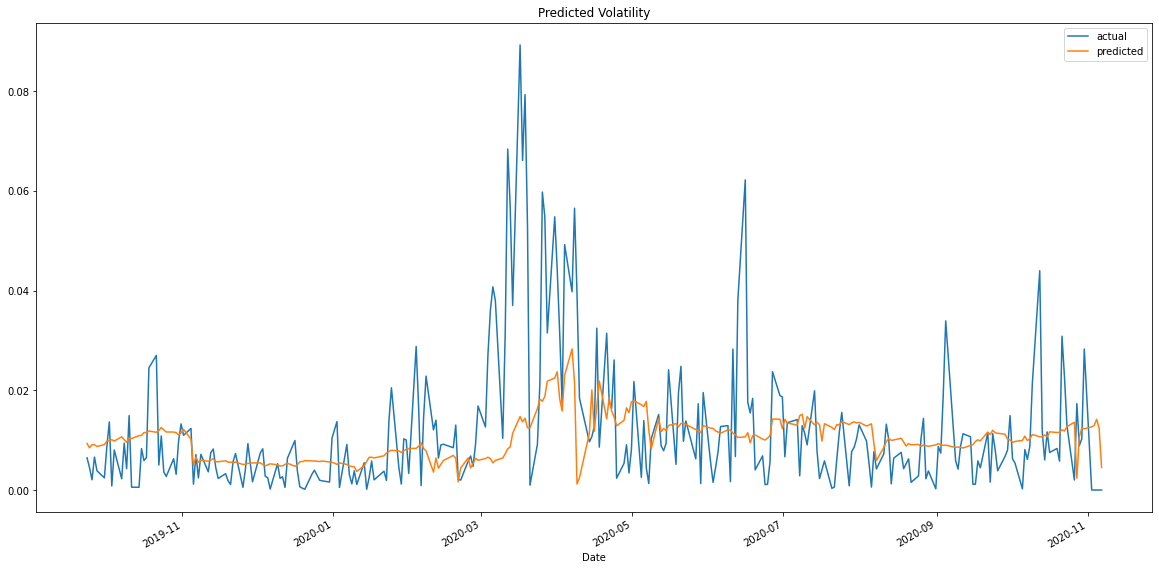

In [485]:
# Plot the real vs predicted values as a line chart
mv_results_df.plot(figsize=(20, 10), title='Predicted Volatility', legend=True)

### out of sample predictions, comparing with real time values

In [486]:
real = df_ibm['Volatility']['2020-10-01':]

<AxesSubplot:xlabel='Date'>

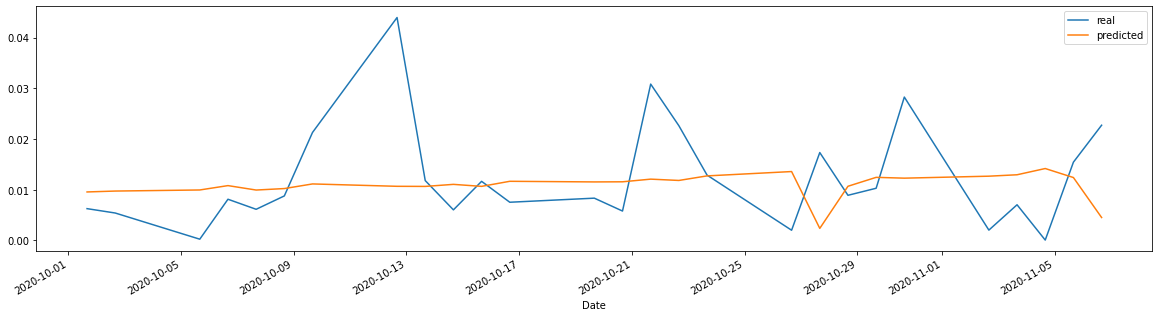

In [487]:
pred=mv_results_df.predicted['2020-10-01':]
future=pd.DataFrame({'real':real, 'predicted':pred})
future.plot(figsize=(20,5))

# Feature engineering using technical indicators and selecting the important features to be fed to LSTM

In [247]:
def get_technical_indicators(df):
    # Create 5 and 20 days Moving Average
    df['ma5'] = df['Close'].rolling(window=5).mean()
    df['ma20'] = df['Close'].rolling(window=20).mean()
    
    # Create MACD
    df['26ema'] = df['Close'].ewm(span=26).mean()
    df['12ema'] = df['Close'].ewm(span=12).mean()
    df['MACD'] = (df['12ema']-df['26ema'])

    # Create Bollinger Bands
    df['5std'] = df['Close'].rolling(window=5).std()
    df['upper_band'] = df['ma20'] + (df['5std']*2)
    df['lower_band'] = df['ma20'] - (df['5std']*2)
    df['bolinger_delta']=df['upper_band']-df['lower_band']
    # Create Exponential moving average
    df['ema'] = df['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    df['momentum'] = df['Close'].diff()
    df['log_momentum'] = np.log(df['momentum'])
    
    return df

In [248]:
def plot_technical_indicators(df, ndays):
    plt.figure(figsize=(16, 10), dpi=100)
    shape_0 = df.shape[0]
    xmacd_ = shape_0-ndays
    
    df = df.iloc[-ndays:, :]
    x_ = range(3, df.shape[0])
    x_ =list(df.index)
    
    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(df['ma5'],label='MA 5', color='g',linestyle='--')
    plt.plot(df['Close'],label='Closing Price', color='b')
    plt.plot(df['ma20'],label='MA 20', color='r',linestyle='--')
    plt.plot(df['upper_band'],label='Upper Band', color='c')
    plt.plot(df['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, df['lower_band'], df['upper_band'], alpha=0.35)
    plt.title('Technical indicators for IBM - last {} days.'.format(ndays))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(df['MACD'],label='MACD', linestyle='-.')
    plt.plot(df['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

In [249]:
tech_ind_df = get_technical_indicators(df_ibm.copy())
tech_ind_df.dropna(inplace=True)
tech_ind_df.head()

,Close,Volume,Returns,Volatility,VIX,ma5,ma20,26ema,12ema,MACD,5std,upper_band,lower_band,bolinger_delta,ema,momentum,log_momentum
Date,,,,,,,,,,,,,,,,,
2017-02-02 16:00:00,174.58,2620386,0.001664,0.002982,17.93,175.298,171.3430,172.768364,174.007028,1.238664,1.264603,173.872205,168.813795,5.058411,174.577983,0.29,-1.237874
2017-02-03 16:00:00,175.82,3309258,0.007103,0.001491,17.19,175.002,171.6990,173.050449,174.294559,1.244110,0.745533,173.190067,170.207933,2.982133,175.405994,1.24,0.215111
2017-02-06 16:00:00,175.86,2650535,0.000228,0.002719,17.39,175.014,172.0155,173.305473,174.541659,1.236186,0.761892,173.539285,170.491715,3.047570,175.708665,0.04,-3.218876
2017-02-07 16:00:00,178.46,3873250,0.014784,0.003438,16.95,175.802,172.5560,173.765668,175.157692,1.392024,1.646821,175.849642,169.262358,6.587285,177.542888,2.60,0.955511
2017-02-09 16:00:00,177.21,3090710,0.005903,0.013808,16.48,176.704,173.5615,174.257531,175.612190,1.354659,1.131207,175.823915,171.299085,4.524829,177.015876,1.04,0.039221


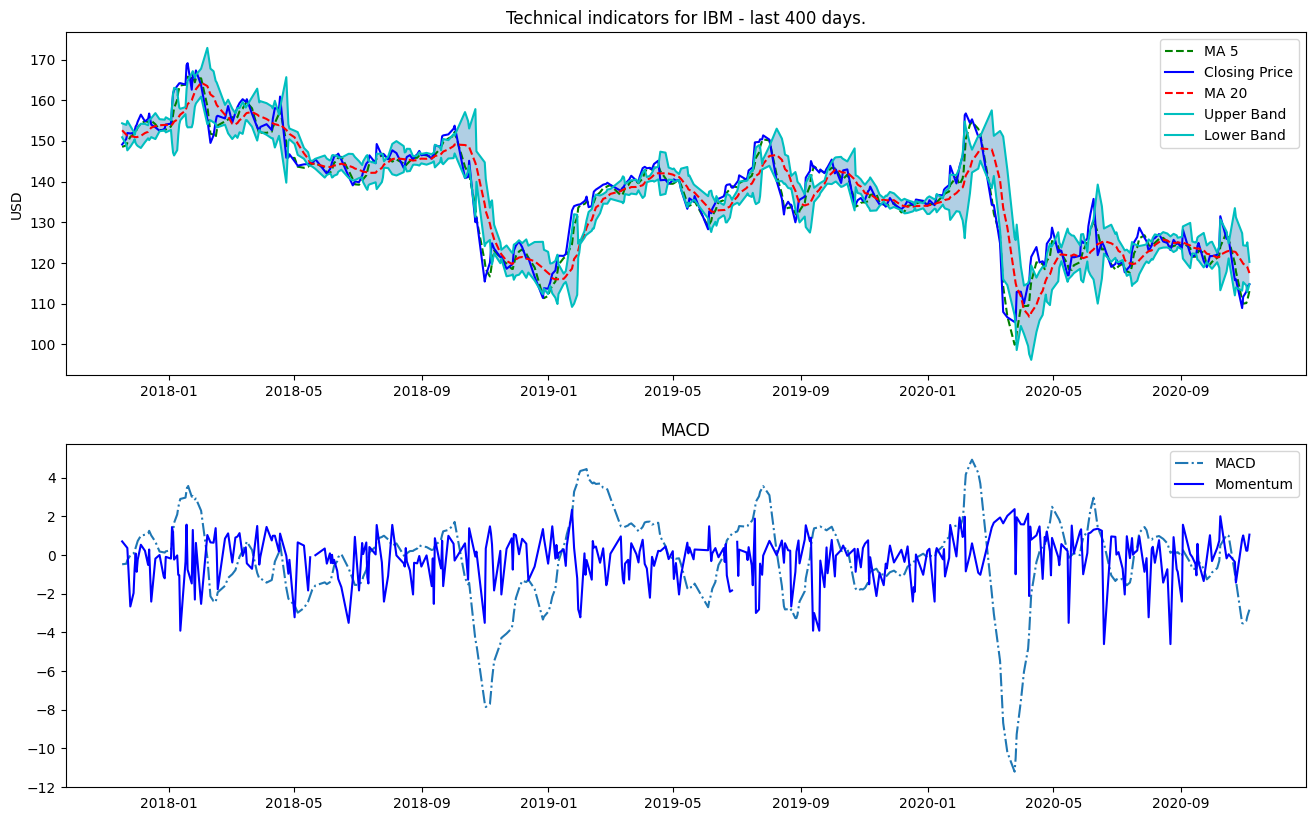

In [250]:
plot_technical_indicators(tech_ind_df, 400)

In [251]:
def get_xg_train_test_data(data): #This is for XGBoost
    df = data.copy()
    y = df['Volatility']
    X = df.drop('Volatility', axis=1)
    
    train_samples = int(X.shape[0] * 0.7)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [252]:
# Get training and test data
(X_train, y_train), (X_test, y_test) = get_xg_train_test_data(tech_ind_df)

In [253]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [254]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.07)

In [255]:
xgbModel = regressor.fit(X_train,y_train, 
                         eval_set = [(X_train, y_train), (X_test, y_test)], 
                         verbose=False)

In [256]:
eval_result = regressor.evals_result()

In [257]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

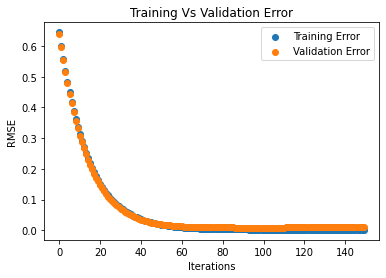

In [258]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

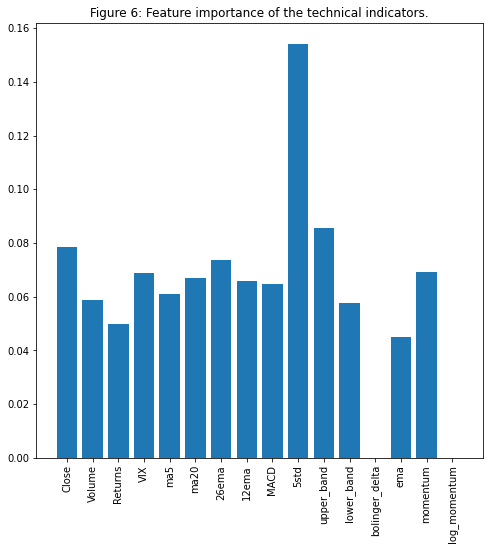

In [259]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

In [261]:
df_xgb=tech_ind_df[['Close', 'Volume', 'VIX', '26ema', '5std', 'upper_band', 'momentum', 'Volatility']].copy()

In [ ]:
#tech_ind_df.head()

In [488]:
window_size = 5 
feature_column = 3   
target_column = 7    
features = [0, 1, 2, 3, 4, 5, 6] # pass the list of features. index # of hte feature column - updated 11/12
forecast = 5 # # of days to forecast. We will use historical data to forecast 1 day ahead
X, y = window_data(df_xgb.loc[:'2020-11-01'], 
                   features, window_size, feature_column, target_column, forecast)

In [489]:
X_train, X_test, y_train, y_test = get_scaled_data(X, y)

In [490]:
X_train.shape

(338, 5, 7)

In [491]:
X_train = np.reshape(X_train, (X_train.shape[0], len(features), X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], len(features), X_test.shape[1]))

In [492]:
X_train.shape

(338, 7, 5)

In [501]:
#build & compile the model by calling the function and passing the parameters
batch_size=5
units=15
dropout=0.2
loss='mean_squared_error'
optimizer='adam'
emb_size=len(features)
xg_model = build_compile_model(units, dropout, X_train, loss, optimizer, emb_size)

In [502]:
xg_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_93 (LSTM)               (None, 7, 15)             1260      
_________________________________________________________________
dropout_93 (Dropout)         (None, 7, 15)             0         
_________________________________________________________________
lstm_94 (LSTM)               (None, 7, 15)             1860      
_________________________________________________________________
dropout_94 (Dropout)         (None, 7, 15)             0         
_________________________________________________________________
lstm_95 (LSTM)               (None, 15)                1860      
_________________________________________________________________
dropout_95 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [503]:
xg_model.fit(X_train, y_train, validation_split=0.2, batch_size=batch_size, 
             epochs=100, shuffle=False, verbose=0)

In [504]:
xg_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

15/15 [==============================] - 0s 6ms/step - loss: 0.0338


0.03380442410707474

In [505]:
xg_results = get_predictions(X_test, y_test, df_xgb, xg_model)
xg_results_df = pd.DataFrame({'actual':xg_results[1].ravel(), 'predicted': xg_results[0].ravel()}, 
                             index=df_xgb.index[-len(xg_results[1]):])
xg_results_df['actual']= xg_results_df['actual'].shift(-5).fillna(0)
xg_results_df.tail()

,actual,predicted
Date,,
2020-10-29 16:00:00,0.0,0.009384
2020-10-30 16:00:00,0.0,0.008664
2020-11-02 16:00:00,0.0,0.009230
2020-11-03 16:00:00,0.0,0.010063
2020-11-05 16:00:00,0.0,0.009337


<AxesSubplot:xlabel='Date'>

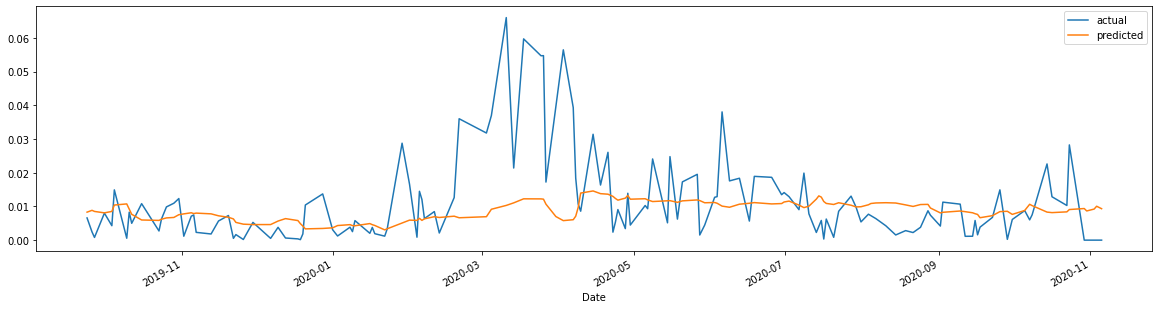

In [506]:
xg_results_df.plot(figsize=(20,5))

# Dimensionality reduction using PCA and configuring LSTM

In [319]:
from sklearn.decomposition import PCA

In [365]:
tech_ind_df = tech_ind_df.drop('log_momentum', axis=1)
tech_ind_df.describe()

,Close,Volume,Returns,Volatility,VIX,ma5,ma20,26ema,12ema,MACD,5std,upper_band,lower_band,bolinger_delta,ema,momentum
count,496.000000,4.960000e+02,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000,496.000000
mean,141.340706,4.641627e+06,0.010172,0.007967,25.254919,140.373730,140.535641,140.777914,140.493529,-0.284384,1.684900,143.905442,137.165841,6.739601,140.911332,1.347863
std,15.401764,2.948352e+06,0.012840,0.009129,8.777994,15.576499,15.161043,14.796754,15.227477,2.302748,1.366183,14.758898,16.025636,5.464730,15.481123,1.548065
min,105.480000,1.818000e+03,0.000000,0.000033,13.820000,99.906000,106.793000,114.212665,107.204837,-11.198962,0.175300,114.435289,96.175786,0.701199,102.208364,0.000000
25%,132.180000,3.092623e+06,0.002775,0.002302,19.097500,130.827000,129.852500,129.768369,130.916476,-1.427675,0.752033,134.270332,125.979912,3.008132,131.108807,0.420000
50%,142.045000,3.861060e+06,0.006452,0.005295,23.205000,141.100000,141.837000,140.804423,141.475044,-0.032231,1.308223,144.556090,138.407613,5.232893,141.865586,0.900000
75%,151.525000,5.193546e+06,0.011865,0.009617,28.872500,151.050500,150.934250,150.599225,150.647123,1.166748,2.112517,153.589351,147.692323,8.450067,151.299197,1.630000
max,181.950000,3.049019e+07,0.113010,0.066081,71.890000,181.038000,180.171000,178.934070,180.242516,4.926475,8.771335,183.159290,178.156074,35.085341,181.407375,12.990000


In [366]:
from sklearn.feature_extraction import DictVectorizer
pca_dict = tech_ind_df.to_dict(orient='records') # turn each row as key-value pairs
dvect = DictVectorizer(sparse=False) 
scaled_data = dvect.fit_transform(pca_dict)

In [367]:
# Initialize PCA model
pca = PCA(n_components=3)
# Get two principal components for the data.
xg_pca3 = pca.fit_transform(scaled_data)
#tech_ind_pca3[0:5]
sum(pca.explained_variance_ratio_)

0.9999999999924241

In [368]:
xg_pca3[:1]

array([[-2.02124115e+06,  8.86331820e+01,  4.47901610e+00]])

In [369]:
pca_df = pd.DataFrame(xg_pca3)
pca_df['RV']=tech_ind_df['Volatility'].values
#pca_df.index.name='Volaitlity'
pca_df.index = tech_ind_df.index

In [370]:
pca_df.head()

,0,1,2,RV
Date,,,,
2017-02-02 16:00:00,-2.021241e+06,88.633182,4.479016,0.002982
2017-02-03 16:00:00,-1.332369e+06,91.178383,2.075304,0.001491
2017-02-06 16:00:00,-1.991092e+06,90.661018,2.975460,0.002719
2017-02-07 16:00:00,-7.683771e+05,95.437840,3.440044,0.003438
2017-02-09 16:00:00,-1.550917e+06,95.327034,3.266748,0.013808


In [371]:
window_size = 5 
feature_column = 3   
target_column = 3    
features = [0, 1, 2] # pass the list of features. index # of hte feature column - updated 11/12
forecast = 5 # # of days to forecast. We will use historical data to forecast 1 day ahead
X, y = window_data(pca_df.loc[:'2020-11-01'], features, window_size, feature_column, target_column, forecast)

In [372]:
X_train, X_test, y_train, y_test = get_scaled_data(X, y)

In [373]:
X_train = np.reshape(X_train, (X_train.shape[0], len(features), X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], len(features), X_test.shape[1]))

In [374]:
X_train.shape

(338, 3, 5)

In [375]:
units=200
dropout=0.2
loss='mean_squared_error'
optimizer='adam'
emb_size=5
pc_model = build_compile_model(units, dropout, X_train, loss, optimizer, emb_size)

In [376]:
pc_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 3, 200)            164800    
_________________________________________________________________
dropout_60 (Dropout)         (None, 3, 200)            0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 3, 200)            320800    
_________________________________________________________________
dropout_61 (Dropout)         (None, 3, 200)            0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dropout_62 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)               

In [377]:
pc_model.fit(X_train, y_train, validation_split=0.2, batch_size=100, epochs=50, shuffle=False, verbose=0)

In [378]:
pc_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

15/15 [==============================] - 0s 16ms/step - loss: 0.0333


0.03328957036137581

In [379]:
pc_results = get_predictions(X_test, y_test, pca_df, pc_model)
pc_results_df = pd.DataFrame({'actual':pc_results[1].ravel(), 'predicted': pc_results[0].ravel()}, 
                             index=pca_df.index[-len(pc_results[1]):])
pc_results_df['actual']= pc_results_df['actual'].shift(-5).fillna(0)
pc_results_df.tail()

,actual,predicted
Date,,
2020-10-29 16:00:00,0.0,0.008955
2020-10-30 16:00:00,0.0,0.008915
2020-11-02 16:00:00,0.0,0.008521
2020-11-03 16:00:00,0.0,0.009024
2020-11-05 16:00:00,0.0,0.008754


<AxesSubplot:xlabel='Date'>

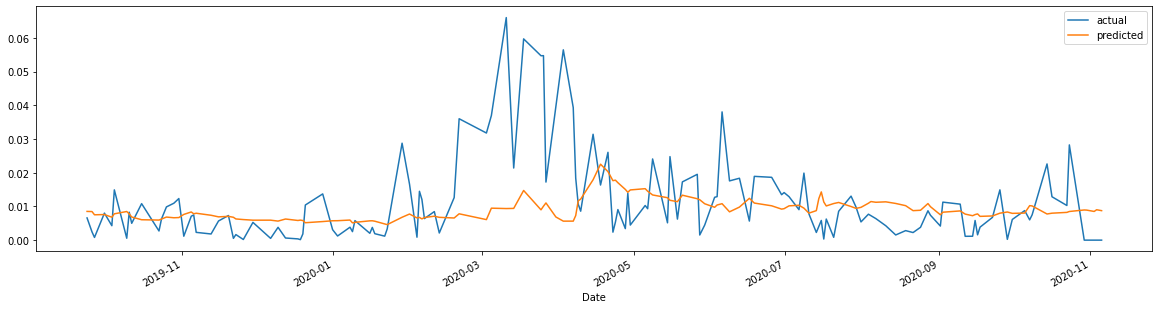

In [380]:
pc_results_df.plot(figsize=(20,5))